In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy import ndimage
from PIL import Image
import matplotlib.image as img


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

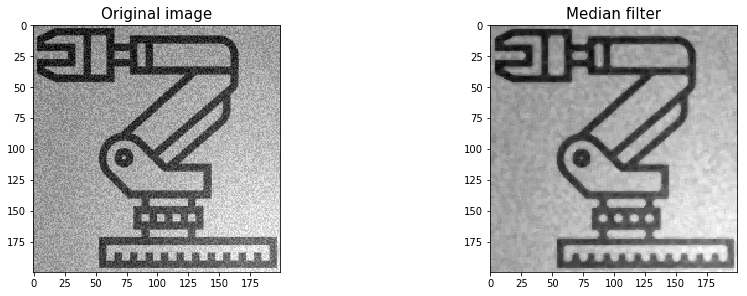

In [2]:
imgg = img.imread('./196.png')
flt = ndimage.median_filter(imgg, 4)
blurred_f = ndimage.gaussian_filter(imgg, 3)
filter_blurred_l = ndimage.gaussian_filter(blurred_f, 1)
alpha = 15
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_l)
fig = plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(imgg, cmap='gray')
plt.title("Original image", fontsize=15)
plt.subplot(222)
plt.imshow(flt, cmap='gray')
plt.title("Median filter", fontsize=15)

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


0.933437
-inf


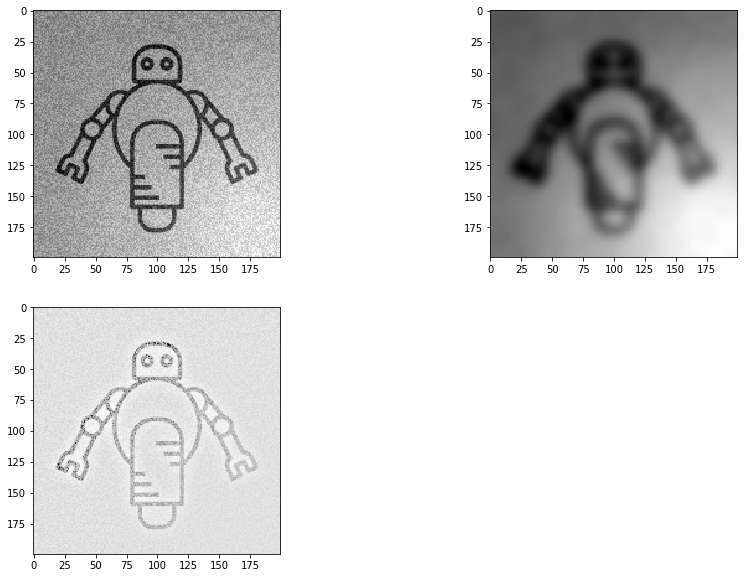

In [3]:
imgg = img.imread('./97.png')
gaus = ndimage.gaussian_filter(imgg, 5)
fig = plt.figure(figsize=(15,10))
diff = np.log2(imgg) - np.log2(gaus)
maxi = diff.max()
mini = diff.min()
print(maxi)
print(mini)
imk = (diff - mini)/(maxi - mini)
plt.subplot(221)
plt.imshow(imgg, cmap='gray')
plt.subplot(222)
plt.imshow(gaus, cmap='gray')
plt.subplot(223)
plt.imshow(diff, cmap='gray')
plt.show()

In [4]:
image_size = 30 # Pixel width and height.
size = image_size,image_size
pixel_depth = 255.0 # Number of levels per pixel.
sizes = [784,622,222,473]
folders = [
    r'data2//Arms//',
    r'data2//Figure_normal_legs//',
    r'data2//FigureWheels//',
    r'data2//Head//',
]

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      img = Image.open(image_file)
      smaller_img = img.resize(size, Image.ANTIALIAS)
      image_array = np.array(smaller_img)
      image_data = (image_array.astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

X_datasets = list()
print(X_datasets)
Y_datasets = list()
for idx in range(len(folders)):
    folder = folders[idx] 
    X_datasets.append(load_letter(folder, sizes[idx]))
    labels = np.zeros((X_datasets[-1].shape[0],len(folders)))
    labels[:,idx] = 1
    Y_datasets.append(labels)
    

[]
data2//Arms//
Full dataset tensor: (784, 30, 30)
Mean: 0.112802
Standard deviation: 0.14514
data2//Figure_normal_legs//
Full dataset tensor: (622, 30, 30)
Mean: 0.0884223
Standard deviation: 0.165164
data2//FigureWheels//
Full dataset tensor: (222, 30, 30)
Mean: 0.0751233
Standard deviation: 0.168167
data2//Head//
Full dataset tensor: (473, 30, 30)
Mean: 0.0372897
Standard deviation: 0.202716


Total samples number: (2101, 30, 30)
Samples for tests: 526
Samples for trains: 1575


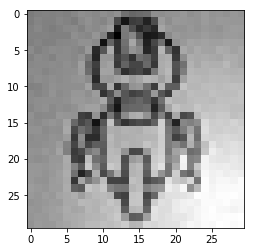

In [5]:
from sklearn.model_selection import train_test_split

X_datasets2 = np.concatenate(X_datasets)
Y_datasets2 = np.concatenate(Y_datasets)
print("Total samples number:",X_datasets2.shape)
X_trains,X_tests,Y_trains,Y_tests = train_test_split(X_datasets2,Y_datasets2,test_size=0.25)
print("Samples for tests:",Y_tests.shape[0])
print("Samples for trains:",Y_trains.shape[0])
plt.imshow(X_tests[0],cmap='gray')

In [9]:
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Reshape
from keras.callbacks import EarlyStopping,ModelCheckpoint
import numpy

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.00001, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint(filepath='./weights.net', verbose=1, save_best_only=True),
    
]

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

input_dim = X_trains[0].shape[0]*X_trains[0].shape[1]
print((X_trains[0].shape[0],X_trains[0].shape[1]))
print(Y_trains[0].shape[0])
# create model
model = Sequential()
model.add(Reshape((input_dim,), input_shape=(X_trains[0].shape[0],X_trains[0].shape[1])))
model.add(Dense(input_dim, input_shape = (input_dim,), init='uniform', activation='relu'))
model.add(Dense(int(input_dim/2), init='uniform', activation='relu'))
model.add(Dense(int(input_dim/4), init='uniform', activation='relu'))
model.add(Dense(Y_trains[0].shape[0],init='uniform', name="output"))
model.add(Activation('softmax', name="softmax"))
model.summary()

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X_trains, 
          Y_trains, 
          epochs=50, 
          batch_size=50)
# calculate predictions
results = model.evaluate(X_tests, Y_tests, batch_size=50, verbose=1, sample_weight=None)
# round predictions
print(results)

(30, 30)
4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 900)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 900)               810900    
_________________________________________________________________
dense_8 (Dense)              (None, 450)               405450    
_________________________________________________________________
dense_9 (Dense)              (None, 225)               101475    
_________________________________________________________________
output (Dense)               (None, 4)                 904       
_________________________________________________________________
softmax (Activation)         (None, 4)                 0         
Total params: 1,318,729
Trainable params: 1,318,729
Non-trainable params: 0
_______________________________________________________

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(900, input_shape=(900,), activation="relu", kernel_initializer="uniform")`
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(450, activation="relu", kernel_initializer="uniform")`
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(225, activation="relu", kernel_initializer="uniform")`
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, name="output", kernel_initializer="uniform")`


Epoch 1/50
1575/1575 [==============================] - 2s 1ms/step - loss: 0.3581 - acc: 0.8487
Epoch 2/50
1575/1575 [==============================] - 1s 613us/step - loss: 0.2174 - acc: 0.9127
Epoch 3/50
1575/1575 [==============================] - 1s 599us/step - loss: 0.1805 - acc: 0.9243
Epoch 4/50
1575/1575 [==============================] - 1s 600us/step - loss: 0.1315 - acc: 0.9452
Epoch 5/50
1575/1575 [==============================] - 1s 602us/step - loss: 0.0951 - acc: 0.9635
Epoch 6/50
1575/1575 [==============================] - 1s 598us/step - loss: 0.0715 - acc: 0.9727
Epoch 7/50
1575/1575 [==============================] - 1s 740us/step - loss: 0.0574 - acc: 0.9786
Epoch 8/50
1575/1575 [==============================] - 1s 649us/step - loss: 0.0401 - acc: 0.9841
Epoch 9/50
1575/1575 [==============================] - 1s 645us/step - loss: 0.0297 - acc: 0.9883
Epoch 10/50
1575/1575 [==============================] - 1s 768us/step - loss: 0.0251 - acc: 0.9900
Epoch 11/50

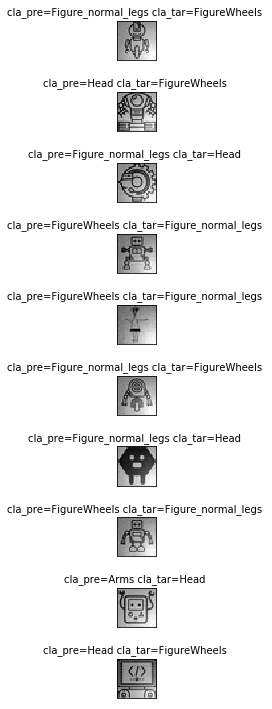

In [10]:
clazzez = ['Arms','Figure_normal_legs','FigureWheels','Head']
results = model.predict(X_tests)
errors = list()
for idx in range(len(results)):
    res = results[idx]
    cla_pre = clazzez[np.argmax(res)]
    cla_tar = clazzez[np.argmax(Y_tests[idx])]
    if cla_pre!=cla_tar:
#         print(cla_pre,cla_tar)
        errors.append(idx)
# print(errors)

problems = 10
fig, axes = plt.subplots(problems, figsize=(10,10))
fig.tight_layout()
for idx in range(problems):
    err = errors[idx]
    cla_pre = clazzez[np.argmax(results[err])]
    cla_tar = clazzez[np.argmax(Y_tests[err])]    
    
    axes[idx].imshow(X_tests[err],cmap='gray')
    axes[idx].set_title("cla_pre=%s cla_tar=%s " % (cla_pre,cla_tar), fontsize=10)
    axes[idx].set_xticks([]) 
    axes[idx].set_yticks([]) 